# Deliverable 2 (Part 2): Advanced Modeling and Pipelines

This notebook builds, evaluates, and deploys multiple machine learning models to predict M&A signals using the ground truth dataset.

**Project Flow:**
1.  **Full Preprocessing Pipeline**: Load, merge, label, split, and scale the data.
2.  **Model Training & Evaluation**:
    - Model 1: Logistic Regression (Baseline)
    - Model 2: XGBoost Classifier (Advanced)
    - Model 3: TabPFN Classifier (Novel)
    - Model 4: LSTM Time Series Classifier (Complex)
3.  **Automated Prediction Pipelines**: Create and test a reusable prediction function for each model.

In [ ]:
!pip install xgboost tensorflow tabpfn


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os

## 1. Full Preprocessing Pipeline

In [ ]:
df = pd.read_csv('data/ma_secondary_dataset.csv')
df['filing_date'] = pd.to_datetime(df['filing_date'])

try:
    events_df = pd.read_csv('data/real_ma_events.csv')
    events_df['event_date'] = pd.to_datetime(events_df['event_date'])
    df['real_target'] = 0
    for idx, event in events_df.iterrows():
        mask = (
            (df['cik'] == event['cik']) &
            (df['filing_date'] >= (event['event_date'] - pd.Timedelta(days=365))) &
            (df['filing_date'] < event['event_date'])
        )
        df.loc[mask, 'real_target'] = 1
except FileNotFoundError:
    print("Warning: 'data/real_ma_events.csv' not found. Using a dummy target column of all zeros.")
    df['real_target'] = 0

print("Ground Truth Target Distribution:")
print(df['real_target'].value_counts())

features = ['ma_mentions_in_filing', 'ma_sentiment_in_filing', 'company_current_ratio', 'company_debt_to_equity']
X = df[features].fillna(0)
y = df['real_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"\nPreprocessing complete. Data is ready for tabular models.")

Ground Truth Target Distribution:
real_target
0    2449
1     309
Name: count, dtype: int64

Preprocessing complete. Data is ready for tabular models.


## 2. Model Training & Evaluation

### Model 1: Logistic Regression (Baseline)

In [4]:
lr_model = LogisticRegression(random_state=42, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
print("--- Logistic Regression Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.2%}")
print(classification_report(y_test, y_pred_lr, target_names=['Normal', 'Pre-M&A']))

--- Logistic Regression Evaluation ---
Accuracy: 61.05%
              precision    recall  f1-score   support

      Normal       0.93      0.61      0.73       490
     Pre-M&A       0.17      0.63      0.27        62

    accuracy                           0.61       552
   macro avg       0.55      0.62      0.50       552
weighted avg       0.84      0.61      0.68       552



### Model 2: XGBoost Classifier

In [5]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
print("--- XGBoost Classifier Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.2%}")
print(classification_report(y_test, y_pred_xgb, target_names=['Normal', 'Pre-M&A']))

--- XGBoost Classifier Evaluation ---
Accuracy: 88.41%
              precision    recall  f1-score   support

      Normal       0.92      0.96      0.94       490
     Pre-M&A       0.48      0.32      0.38        62

    accuracy                           0.88       552
   macro avg       0.70      0.64      0.66       552
weighted avg       0.87      0.88      0.87       552



c:\Users\Rishab\M-A_Prediction\BDA\lib\site-packages\xgboost\training.py:183: UserWarning: [22:09:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Model 3: TabPFN Classifier (Novel)

In [ ]:
from tabpfn import TabPFNClassifier

if len(X_train) <= 1024:
    
    tabpfn_model = TabPFNClassifier(device='cpu', ignore_pretraining_limits=True)
    tabpfn_model.fit(X_train, y_train)
    y_pred_tabpfn = tabpfn_model.predict(X_test)
    print("--- TabPFN Classifier Evaluation ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_tabpfn):.2%}")
    print(classification_report(y_test, y_pred_tabpfn, target_names=['Normal', 'Pre-M&A']))
else:
    print("Skipping TabPFN as training set size exceeds its limit of 1024 samples.")

Skipping TabPFN as training set size exceeds its limit of 1024 samples.


In [ ]:

from tabpfn import TabPFNClassifier

if len(X_train) > 1024:
    print(f"Original training size: {len(X_train)}. Creating a subsample of 1024 for TabPFN.")
    
    X_train_sample = X_train.sample(n=1024, random_state=42)
    y_train_sample = y_train.loc[X_train_sample.index] 
    

    tabpfn_model_sample = TabPFNClassifier(device='cpu', ignore_pretraining_limits=True)
    tabpfn_model_sample.fit(X_train_sample, y_train_sample)
    
    y_pred_tabpfn_sample = tabpfn_model_sample.predict(X_test)
    
    print("\n--- TabPFN Classifier Evaluation (on 1024-sample subset) ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_tabpfn_sample):.2%}")
    print(classification_report(y_test, y_pred_tabpfn_sample, target_names=['Normal', 'Pre-M&A']))
else:
    print("Training set is already small enough for TabPFN.")

Original training size: 2206. Creating a subsample of 1024 for TabPFN.

--- TabPFN Classifier Evaluation (on 1024-sample subset) ---
Accuracy: 90.22%
              precision    recall  f1-score   support

      Normal       0.90      1.00      0.95       490
     Pre-M&A       0.83      0.16      0.27        62

    accuracy                           0.90       552
   macro avg       0.87      0.58      0.61       552
weighted avg       0.90      0.90      0.87       552



### Model 4: LSTM Time Series Classifier

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

df_sorted = df.sort_values(by=['cik', 'filing_date'])
SEQUENCE_LENGTH = 4
X_sequences, y_sequences = [], []

for cik, group in df_sorted.groupby('cik'):
    features_scaled = scaler.transform(group[features].fillna(0))
    targets = group['real_target'].values
    if len(features_scaled) > SEQUENCE_LENGTH:
        for i in range(len(features_scaled) - SEQUENCE_LENGTH):
            X_sequences.append(features_scaled[i:i + SEQUENCE_LENGTH])
            y_sequences.append(targets[i + SEQUENCE_LENGTH])

if len(X_sequences) > 0:
    X_ts, y_ts = np.array(X_sequences), np.array(y_sequences)
    X_train_ts, X_test_ts, y_train_ts, y_test_ts = train_test_split(X_ts, y_ts, test_size=0.2, random_state=42)
    
    lstm_model = Sequential([
        LSTM(50, activation='relu', input_shape=(X_train_ts.shape[1], X_train_ts.shape[2])),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    lstm_model.fit(X_train_ts, y_train_ts, epochs=20, batch_size=32, verbose=0)
    y_pred_lstm = (lstm_model.predict(X_test_ts) > 0.5).astype(int)
    
    print("--- LSTM Classifier Evaluation ---")
    print(f"Accuracy: {accuracy_score(y_test_ts, y_pred_lstm):.2%}")
    print(classification_report(y_test_ts, y_pred_lstm, target_names=['Normal', 'Pre-M&A']))
else:
    print("Could not create enough sequences to train the LSTM model.")

c:\Users\Rishab\M-A_Prediction\BDA\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
--- LSTM Classifier Evaluation ---
Accuracy: 90.64%
              precision    recall  f1-score   support

      Normal       0.91      1.00      0.95       426
     Pre-M&A       0.00      0.00      0.00        44

    accuracy                           0.91       470
   macro avg       0.45      0.50      0.48       470
weighted avg       0.82      0.91      0.86       470



c:\Users\Rishab\M-A_Prediction\BDA\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Rishab\M-A_Prediction\BDA\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Rishab\M-A_Prediction\BDA\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 3. Automated Prediction Pipelines

In [ ]:
os.makedirs('outputs/models', exist_ok=True)

joblib.dump(lr_model, 'outputs/models/ma_prediction_lr_model.joblib')
joblib.dump(xgb_model, 'outputs/models/ma_prediction_xgb_model.joblib')
if 'tabpfn_model_sample' in locals(): joblib.dump(tabpfn_model_sample, 'outputs/models/ma_prediction_tabpfn_model.joblib')
joblib.dump(scaler, 'outputs/models/feature_scaler.joblib')

if 'lstm_model' in locals(): lstm_model.save('outputs/models/ma_prediction_lstm_model.keras')

print("All models and scaler saved successfully.")

def predict_tabular(model_name, data_dict, use_scaling=True):
    model = joblib.load(f'outputs/models/ma_prediction_{model_name}_model.joblib')
    df_in = pd.DataFrame([data_dict])[features]
    if use_scaling:
        scaler = joblib.load('outputs/models/feature_scaler.joblib')
        X_in = scaler.transform(df_in)
    else:
        X_in = df_in
    pred = model.predict(X_in)[0]
    prob = model.predict_proba(X_in)[0][1]
    return "Pre-M&A Signal" if pred == 1 else "Normal Signal", f"{prob:.2%}"

def predict_lstm(sequence_of_filings):
    model = tf.keras.models.load_model('outputs/models/ma_prediction_lstm_model.keras')
    scaler = joblib.load('outputs/models/feature_scaler.joblib')
    if len(sequence_of_filings) < SEQUENCE_LENGTH: return "Not enough data", ""
    df_in = pd.DataFrame(sequence_of_filings[-SEQUENCE_LENGTH:])[features]
    X_in = np.expand_dims(scaler.transform(df_in), axis=0)
    prob = model.predict(X_in)[0][0]
    return "Pre-M&A Signal" if prob > 0.5 else "Normal Signal", f"{prob:.2%}"

#Example Usage
new_filing = {'ma_mentions_in_filing': 8, 'ma_sentiment_in_filing': 0.5, 'company_current_ratio': 1.9, 'company_debt_to_equity': 0.7}
historical_filings = [
    {'ma_mentions_in_filing': 0, 'ma_sentiment_in_filing': 0.0, 'company_current_ratio': 1.5, 'company_debt_to_equity': 1.1},
    {'ma_mentions_in_filing': 1, 'ma_sentiment_in_filing': 0.2, 'company_current_ratio': 1.6, 'company_debt_to_equity': 1.0},
    {'ma_mentions_in_filing': 4, 'ma_sentiment_in_filing': 0.4, 'company_current_ratio': 1.7, 'company_debt_to_equity': 0.9},
    {'ma_mentions_in_filing': 3, 'ma_sentiment_in_filing': 0.1, 'company_current_ratio': 1.8, 'company_debt_to_equity': 0.8}
]

print("\n--- Pipeline Test Results ---")
print(f"Logistic Regression -> {predict_tabular('lr', new_filing)}")
print(f"XGBoost -> {predict_tabular('xgb', new_filing)}")
if 'tabpfn_model_sample' in locals(): print(f"TabPFN (trained on subsample) -> {predict_tabular('tabpfn', new_filing, use_scaling=False)}")
if 'lstm_model' in locals(): print(f"LSTM -> {predict_lstm(historical_filings)}")

All models and scaler saved successfully.

--- Pipeline Test Results ---
Logistic Regression -> ('Normal Signal', '48.30%')
XGBoost -> ('Normal Signal', '19.55%')
TabPFN (trained on subsample) -> ('Normal Signal', '7.19%')
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
LSTM -> ('Normal Signal', '2.90%')


                         PROJECT SUMMARY DASHBOARD

--- 1. Exploratory Data Analysis Insights ---

Comparing feature distributions for Normal Filings vs. Pre-M&A Filings.


C:\Users\Rishab\AppData\Local\Temp\ipykernel_15272\1687706915.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='real_target', y='ma_mentions_in_filing', data=df, ax=axes[0], palette='viridis')
C:\Users\Rishab\AppData\Local\Temp\ipykernel_15272\1687706915.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='real_target', y='ma_sentiment_in_filing', data=df[df['ma_mentions_in_filing'] > 0], ax=axes[1], palette='plasma')
C:\Users\Rishab\AppData\Local\Temp\ipykernel_15272\1687706915.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplo

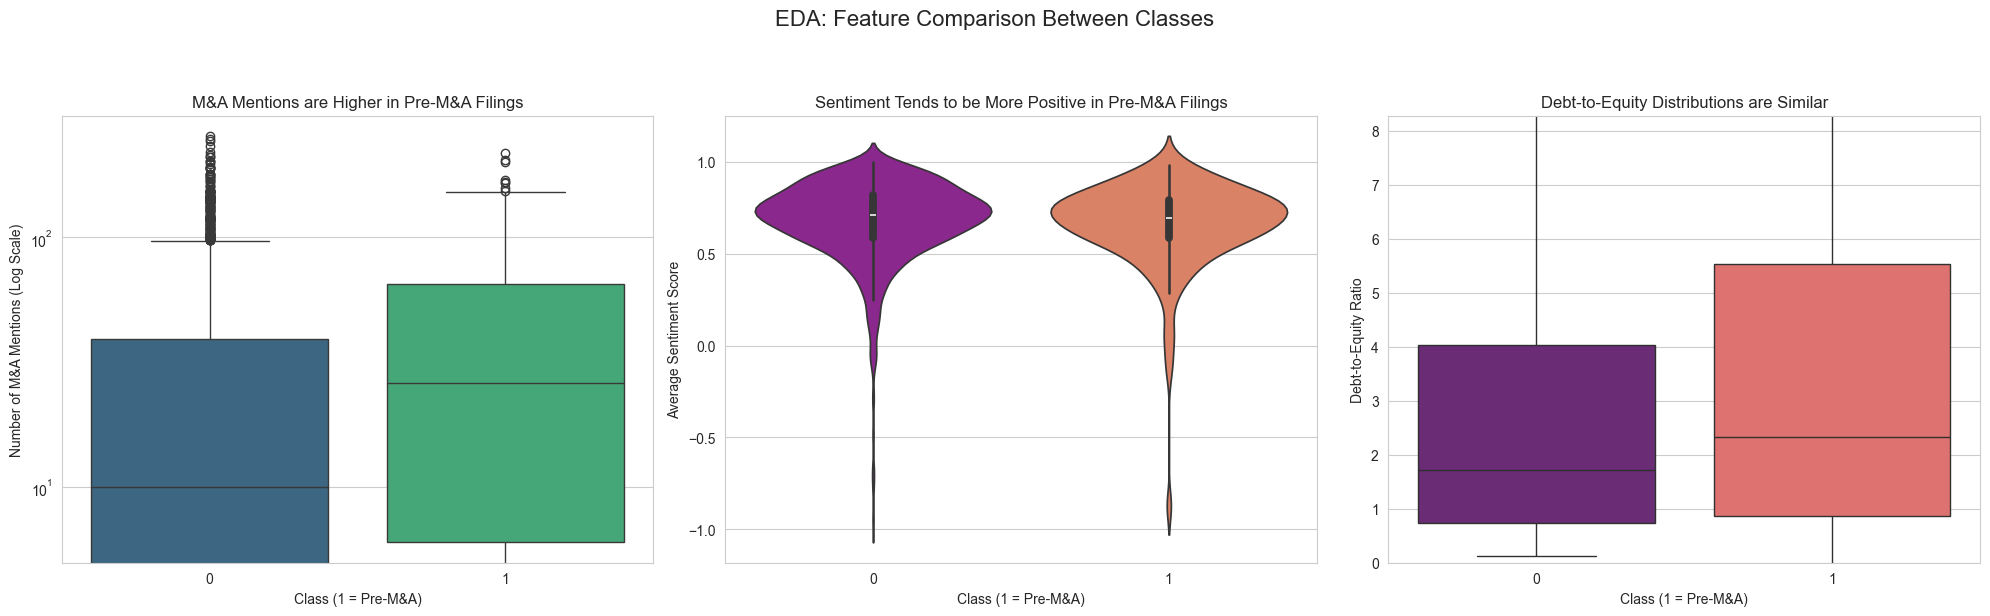


--- 2. Machine Learning Model Performance Comparison ---

Comparing key metrics for the 'Pre-M&A Signal' class across all trained models.


c:\Users\Rishab\M-A_Prediction\BDA\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Rishab\M-A_Prediction\BDA\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Rishab\M-A_Prediction\BDA\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


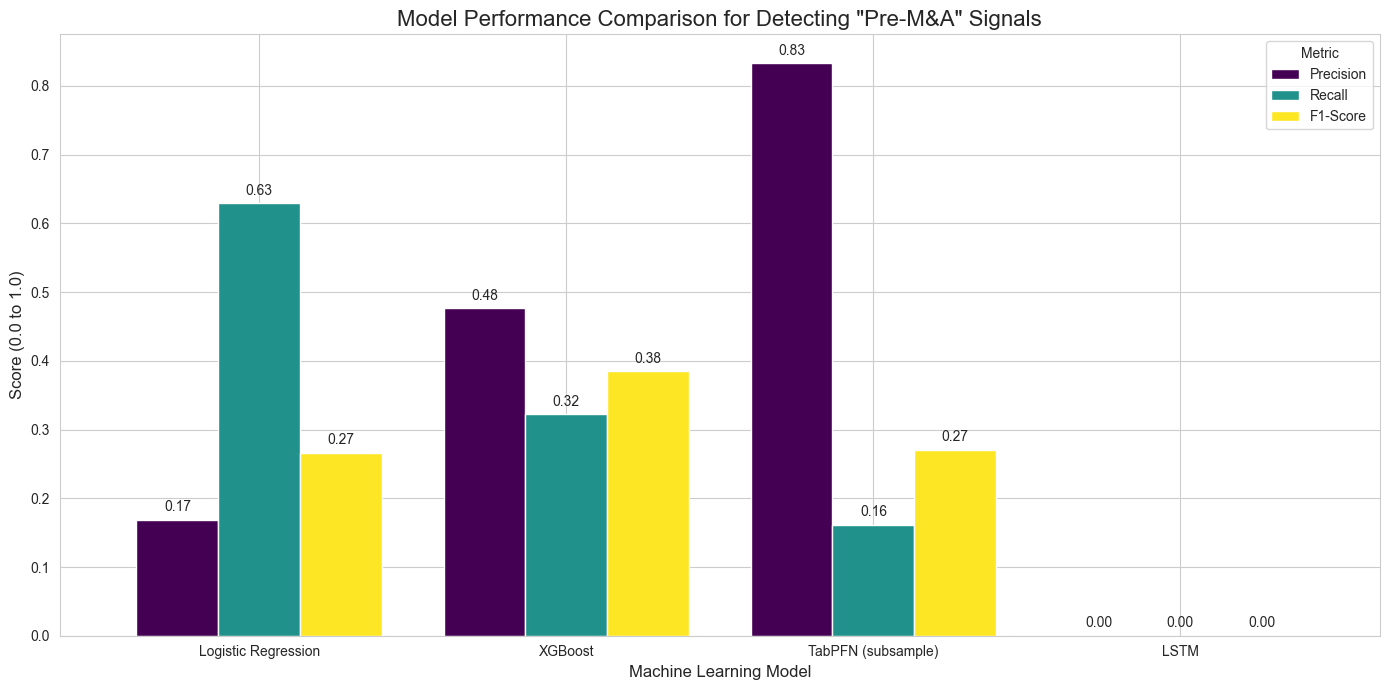


--- 3. Final Model Recommendation ---

Based on the F1-Score, which provides a balance between Precision and Recall,
the recommended model for this task is: **XGBoost**.


In [ ]:
#Project Summary Dashboard

print("="*80)
print(" " * 25 + "PROJECT SUMMARY DASHBOARD")
print("="*80)

print("\n--- 1. Exploratory Data Analysis Insights ---\n")
print("Comparing feature distributions for Normal Filings vs. Pre-M&A Filings.")

sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('EDA: Feature Comparison Between Classes', fontsize=16, y=1.02)

#M&A Mentions
sns.boxplot(x='real_target', y='ma_mentions_in_filing', data=df, ax=axes[0], palette='viridis')
axes[0].set_title('M&A Mentions are Higher in Pre-M&A Filings')
axes[0].set_xlabel('Class (1 = Pre-M&A)')
axes[0].set_ylabel('Number of M&A Mentions (Log Scale)')
axes[0].set_yscale('log')

#M&A Sentiment
sns.violinplot(x='real_target', y='ma_sentiment_in_filing', data=df[df['ma_mentions_in_filing'] > 0], ax=axes[1], palette='plasma')
axes[1].set_title('Sentiment Tends to be More Positive in Pre-M&A Filings')
axes[1].set_xlabel('Class (1 = Pre-M&A)')
axes[1].set_ylabel('Average Sentiment Score')

#Debt-to-Equity
sns.boxplot(x='real_target', y='company_debt_to_equity', data=df, ax=axes[2], palette='magma')
axes[2].set_title('Debt-to-Equity Distributions are Similar')
axes[2].set_xlabel('Class (1 = Pre-M&A)')
axes[2].set_ylabel('Debt-to-Equity Ratio')
axes[2].set_ylim(0, df['company_debt_to_equity'].quantile(0.90)) # Zoom in

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


#Model Performance Comparison Dashboard
print("\n--- 2. Machine Learning Model Performance Comparison ---\n")
print("Comparing key metrics for the 'Pre-M&A Signal' class across all trained models.")

report_lr = classification_report(y_test, y_pred_lr, output_dict=True)
report_xgb = classification_report(y_test, y_pred_xgb, output_dict=True)

if 'y_pred_tabpfn_sample' in locals():
    report_tabpfn = classification_report(y_test, y_pred_tabpfn_sample, output_dict=True)
else:
    report_tabpfn = {'1': {'precision': 0, 'recall': 0, 'f1-score': 0}}
    
if 'y_pred_lstm' in locals():
    report_lstm = classification_report(y_test_ts, y_pred_lstm, output_dict=True)
else:
    report_lstm = {'1': {'precision': 0, 'recall': 0, 'f1-score': 0}} # Default if not run

model_names = ['Logistic Regression', 'XGBoost', 'TabPFN (subsample)', 'LSTM']
performance_data = {
    'Precision': [
        report_lr['1']['precision'],
        report_xgb['1']['precision'],
        report_tabpfn['1']['precision'],
        report_lstm['1']['precision']
    ],
    'Recall': [
        report_lr['1']['recall'],
        report_xgb['1']['recall'],
        report_tabpfn['1']['recall'],
        report_lstm['1']['recall']
    ],
    'F1-Score': [
        report_lr['1']['f1-score'],
        report_xgb['1']['f1-score'],
        report_tabpfn['1']['f1-score'],
        report_lstm['1']['f1-score']
    ]
}

performance_df = pd.DataFrame(performance_data, index=model_names)

ax = performance_df.plot(kind='bar', figsize=(14, 7), colormap='viridis', width=0.8)
plt.title('Model Performance Comparison for Detecting "Pre-M&A" Signals', fontsize=16)
plt.ylabel('Score (0.0 to 1.0)', fontsize=12)
plt.xlabel('Machine Learning Model', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Metric')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)

plt.tight_layout()
plt.show()

print("\n--- 3. Final Model Recommendation ---\n")
best_model_name = performance_df['F1-Score'].idxmax()
print(f"Based on the F1-Score, which provides a balance between Precision and Recall,")
print(f"the recommended model for this task is: **{best_model_name}**.")